# Jane Street Market Prediction 
> Buy low, sell high. It sounds so easy….

- toc: true
- badges: true
- categories: [tabular,stock]

In [7]:
#hide

%%writefile conditional_cell_extension.py
def run_if(line, cell=None):
    '''Execute current line/cell if line evaluates to True.'''
    if not eval(line):
        return
    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the run_if magic when the extension loads.'''
    shell.register_magic_function(run_if, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the run_if magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['run_if']

Overwriting conditional_cell_extension.py


In [8]:
#hide
%reload_ext conditional_cell_extension

# Preliminaries

## Dependencies

In [3]:
!pip install dabl > /dev/null
!pip install datatable > /dev/null

In [4]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, warnings, math, sys, json, pprint, pdb

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import dabl
import datatable as dt

In [5]:
#hide
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
                name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [9]:
#collapse-hide
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

GOOGLE = 'google.colab' in str(get_ipython())
KAGGLE = not GOOGLE

print("Running on {}!".format(
   "Google Colab" if GOOGLE else "Kaggle Kernel"
))

Running on Google Colab!


In [10]:
#hide
%%run_if {GOOGLE}
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [11]:
#hide
project_name = 'jane-street-market-prediction'
root_path  = '/content/gdrive/MyDrive/' if GOOGLE else '/'
input_path = f'{root_path}kaggle/input/{project_name}/'
working_path = f'{input_path}working/' if GOOGLE else '/kaggle/working/'
os.makedirs(working_path, exist_ok=True)
os.chdir(working_path)
os.listdir(input_path)

['working']

In [12]:
#hide
!kaggle competitions download -c jane-street-market-prediction

  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 8.29kB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 28.4MB/s]
100% 2.60G/2.61G [00:26<00:00, 49.7MB/s]
100% 2.61G/2.61G [00:26<00:00, 106MB/s] 
  0% 0.00/108k [00:00<?, ?B/s]
100% 108k/108k [00:00<00:00, 15.2MB/s]
  0% 0.00/23.3k [00:00<?, ?B/s]
100% 23.3k/23.3k [00:00<00:00, 3.31MB/s]
 55% 9.00M/16.4M [00:00<00:00, 40.0MB/s]
100% 16.4M/16.4M [00:00<00:00, 54.6MB/s]


We can observe that the train.csv is large: `6GB` and it has `2390492` rows in the file.

In [18]:
#hide_output
!wc -l {input_path}train.csv

2390492 /content/gdrive/MyDrive/kaggle/input/jane-street-market-prediction/train.csv


To speed things up here, let's use `datatable` to read the data, and then convert to a pandas dataframe.

In [19]:
%%time
train_dt = dt.fread(f"{input_path}train.csv")

CPU times: user 30.1 s, sys: 4.63 s, total: 34.7 s
Wall time: 1min 12s


In [20]:
%%time
train_df = train_dt.to_pandas()

CPU times: user 7.73 s, sys: 9.08 s, total: 16.8 s
Wall time: 13.6 s


# Exploration

2487

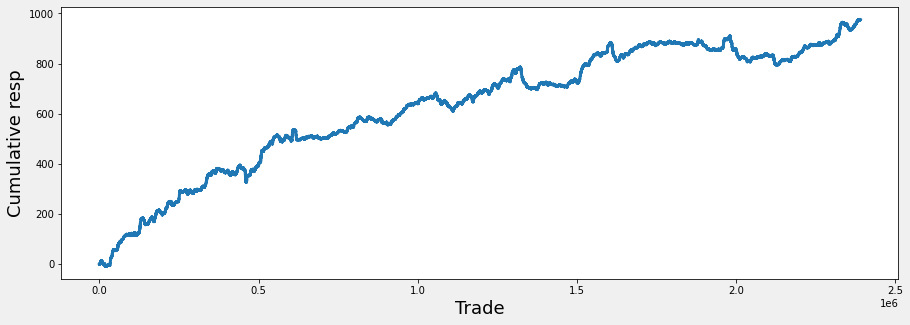

In [24]:
fig,ax = plt.subplots(figsize=(15,5), facecolor="#F0F0F0")
balance = pd.Series(train_df['resp'].cumsum())
ax.set_xlabel("Trade", fontsize=18)
ax.set_ylabel("Cumulative resp", fontsize=18)
balance.plot(lw=3)
del balance
gc.collect()

as well as four [time horizons](https://www.investopedia.com/terms/t/timehorizon.asp)
> The longer the Time Horizon, the more aggressive, or riskier portfolio, ans investor can build. The shorter the Time Horizon, the more conservative, or less risky, the investor may want to adopt.

3382

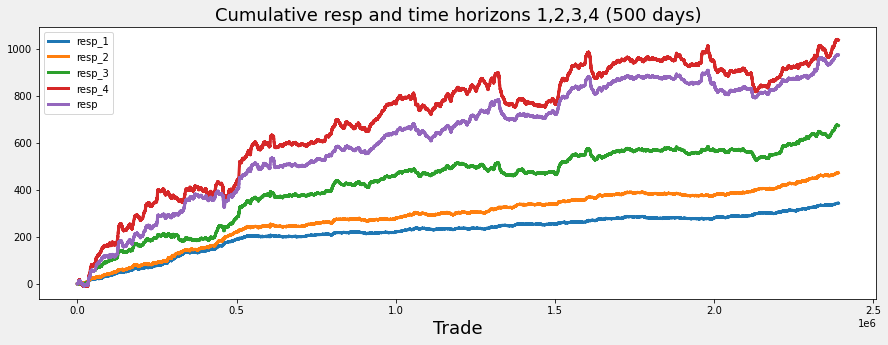

In [30]:
#collapse-hide
fig,ax = plt.subplots(figsize=(15,5), facecolor="#F0F0F0")
resps = []
for colName, colData in train_df.iteritems():
    if ('resp' in colName):
        resps.append(colData.cumsum())
ax.set_xlabel("Trade", fontsize=18)
ax.set_title("Cumulative resp and time horizons 1,2,3,4 (500 days)", fontsize=18)
for r in resps: r.plot(lw=3)
plt.legend(loc="upper left")
del resps; gc.collect()

We can see that `resp` (in purple) most closely follows time horizon 4 (`resp_4` is the uppermost curve, in red).

In the notebook [Jane Street: time horizons and volatilities](https://www.kaggle.com/pcarta/jane-street-time-horizons-and-volatilities) by ***@pcarta***, if I understand correctly, by using maximum likelihood estimation it is calculated that if the time horizon ($T_j$) for `resp_1` (i.e. $T_1$ is 1, then
- $T_j$(resp_2) $\approx 1.4T_1$
- $T_j$(resp_3) $\approx 3.9T_1$
- $T_j$(resp_4) $\approx 11.1T_1$
where $T_1$ could correspond to 5 trading days.
Let's now plot a histogram of all of the `resp` values (here only shown for values between -0.05 and 0.05)


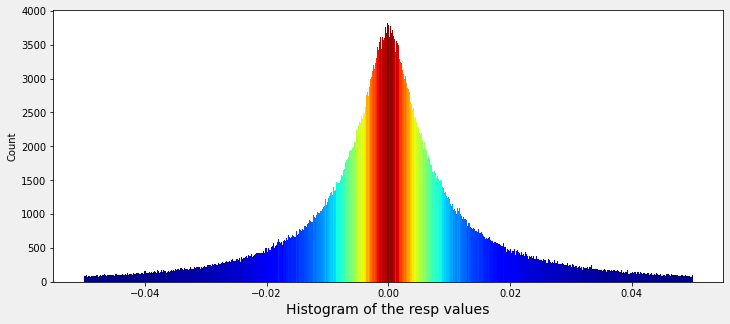

In [51]:
#collapse-hide
fig,ax = plt.subplots(figsize=(12,5), facecolor="#F0F0F0")
sns.histplot(
    ax=ax,
    x=train_df['resp'], 
    bins=3000, 
    kde_kws={"clip":(-0.05,0.05)}, 
    binrange=(-0.05,0.05),
    color='darkcyan', 
    kde=False)
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.show();
del values
gc.collect();

This distribution has very long tails

In [63]:
#collapse-hide
print('The minimum value for resp is : %.5f' %  train_df['resp'].min())
print('The minimum value for resp is :  %.5f' % train_df['resp'].max())

The minimum value for resp is : -0.54938
The minimum value for resp is :  0.44846


Also calculate its' [skew](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) of this distribution

In [64]:
#collapse-hide
print("Skew of resp is:      %.2f" % train_df['resp'].skew() )
print("Kurtosis of resp is: %.2f"  % train_df['resp'].kurtosis() )

Skew of resp is:      0.10
Kurtosis of resp is: 17.36
